In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import torch
torch.__version__

'2.6.0+cu126'

In [11]:
from lstm3 import LSTM_3

from config import filenames, folders

from matplotlib import pyplot as plt

device = 'cuda'

config = {
    'model_name': 'LSTM_3',
    'feature': 'testing-teacher-forcing',
    'max_len': 42,
    # 'max_len': 24,
    'min_freq_src': 5,
    'min_freq_trg': 5,

    'embedding_dim': 128,
    'hidden_size': 256,
    'num_layers': 3,

    # 'embedding_dim': 64,
    # 'hidden_size': 128,
    # 'num_layers': 2,

    'num_epochs': 15,
    'weight_decay': 1e-5,
    'label_smoothing': 0.1,

    'dropout_enc': 0.1,
    'dropout_dec': 0.1,
    'dropout_emb': 0.1,
    'dropout_attention': 0.1,

    'learning_rate': 1e-3,
    'gamma': 0.2,
    'patience': 2,
    'threshold': 5e-4,
    'batch_size': 128
}

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid()
    plt.show()

In [12]:
from dataset2 import Vocab
from config import filenames
vocab_src = Vocab(filenames['train_src'], min_freq=config['min_freq_src'], use_sub=False, use_bpe=True)
vocab_trg = Vocab(filenames['train_trg'], min_freq=config['min_freq_trg'], use_sub=False)

In [36]:
print(len(vocab_src))
print(len(vocab_trg))

23722
18711


In [15]:
ids = vocab_src.encode_line('was wollen sie doch')
for i in range(len(ids)):
    print(vocab_src.decode_idx(ids[i]))

<BOS>
▁was
▁wollen
▁sie
▁doch
<EOS>


In [16]:
vocab_src.vocab['i']
# vocab_src.all_words[2303]

2303

In [17]:
ids

[2, 22487, 22909, 19509, 10121, 3]

In [18]:
vocab_src.tokenizer.tokenize(filenames['train_src'])

[['▁david',
  '▁gall',
  'o',
  '▁:',
  '▁das',
  '▁ist',
  '▁bill',
  '▁lange',
  '▁.',
  '▁ich',
  '▁bin',
  '▁dave',
  '▁gall',
  'o',
  '▁.'],
 ['▁wir',
  '▁werden',
  '▁ihnen',
  '▁einige',
  '▁geschichten',
  '▁über',
  '▁das',
  '▁meer',
  '▁in',
  '▁video',
  'form',
  '▁erzählen',
  '▁.'],
 ['▁wir',
  '▁haben',
  '▁ein',
  '▁paar',
  '▁der',
  '▁unglaublich',
  'sten',
  '▁aufnahmen',
  '▁der',
  '▁titanic',
  '▁,',
  '▁die',
  '▁man',
  '▁je',
  '▁gesehen',
  '▁hat',
  '▁,',
  '▁,',
  '▁und',
  '▁wir',
  '▁werden',
  '▁ihnen',
  '▁nichts',
  '▁davon',
  '▁zeigen',
  '▁.'],
 ['▁die',
  '▁wahrheit',
  '▁ist',
  '▁,',
  '▁dass',
  '▁die',
  '▁titanic',
  '▁–',
  '▁obwohl',
  '▁sie',
  '▁alle',
  '▁kin',
  'ok',
  'assen',
  're',
  'korde',
  '▁bricht',
  '▁–',
  '▁nicht',
  '▁gerade',
  '▁die',
  '▁aufregendste',
  '▁geschichte',
  '▁vom',
  '▁meer',
  '▁ist',
  '▁.'],
 ['▁ich',
  '▁denke',
  '▁,',
  '▁das',
  '▁problem',
  '▁ist',
  '▁,',
  '▁dass',
  '▁wir',
  '▁das',
  '▁mee

In [37]:
from dataset2 import TranslationDataset
train_dataset = TranslationDataset(vocab_src, 
                                vocab_trg, 
                                filenames['train_src'], 
                                filenames['train_trg'], 
                                max_len=48, 
                                device=device,
                                sort_lengths=False)
val_dataset = TranslationDataset(vocab_src, 
                                vocab_trg, 
                                filenames['test_src'], 
                                filenames['test_trg'], 
                                max_len=72, 
                                device=device, 
                                sort_lengths=False)


100%|██████████| 986/986 [00:00<00:00, 6314.76it/s]


In [20]:
vocab_src.decode_idx(93)

'ada'

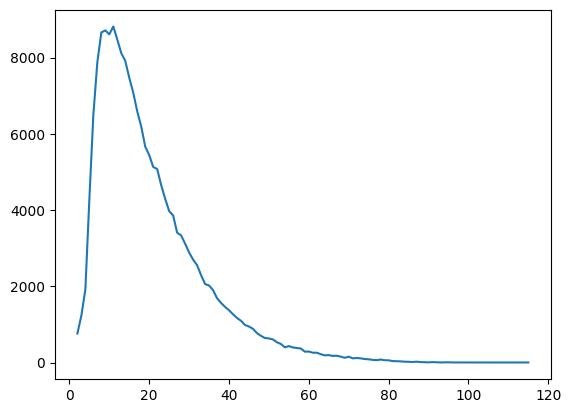

In [35]:
lens = train_dataset.cnt_src.keys()
freq = train_dataset.cnt_src.values()
z = list(zip(lens, freq))

z.sort()
lens = [t[0] for t in z]
freq = [t[1] for t in z]
plt.plot(lens, freq)

In [43]:
from lstm3 import LSTM_3

config['src_vocab_size'] = len(vocab_src)
config['trg_vocab_size'] = len(vocab_trg)
model = LSTM_3(config=config).to(device)

In [ ]:
from submission import get_bleu
from dataset2 import RawDataset, TrainDataLoader, TestDataLoader

train_loader = TrainDataLoader(train_dataset, shuffle=True)
val_loader = TestDataLoader(val_dataset, shuffle=False)

raw_dataset = RawDataset(filenames['test_trg'])
bleu = get_bleu(model, val_loader, vocab_trg, vocab_src, raw_dataset, False, 1, border=0.00/100)
print(f'BLEU4: {bleu:0.2f}')

 25%|██▌       | 1/4 [00:10<00:31, 10.58s/it]

In [ ]:
train_losses, val_losses = train(config=config, 
                                 filenames=filenames, 
                                 folders=folders, 
                                 use_wandb=False, 
                                 device=device, 
                                 vocab_src=vocab_src, 
                                 vocab_trg=vocab_trg,
                                 train_dataset=train_dataset,
                                 val_dataset=val_dataset)

plot_losses(train_losses, val_losses)

LSTM_3(
  (src_embedding): Embedding(24991, 128, padding_idx=1)
  (trg_embedding): Embedding(18710, 128, padding_idx=1)
  (emb_dropout): Dropout(p=0.1, inplace=False)
  (enc_dropout): Dropout(p=0.1, inplace=False)
  (dec_dropout): Dropout(p=0.1, inplace=False)
  (attention_dropout): Dropout(p=0.1, inplace=False)
  (encoder): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.1, bidirectional=True)
  (encoder_output_proj): Linear(in_features=512, out_features=256, bias=True)
  (decoder): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.1)
  (encoder_hidden_proj): ModuleList(
    (0-2): 3 x Linear(in_features=512, out_features=256, bias=True)
  )
  (encoder_cell_proj): ModuleList(
    (0-2): 3 x Linear(in_features=512, out_features=256, bias=True)
  )
  (fc): Linear(in_features=512, out_features=18710, bias=True)
)


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


Epoch [1/15]	Train Loss: 5.2859	Val Loss: 7.9641


 21%|██▏       | 326/1531 [00:58<03:51,  5.21it/s]

In [ ]:
# lstm-2
train_losses, val_losses = train(config=config, 
                                 filenames=filenames, 
                                 folders=folders, 
                                 use_wandb=False, 
                                 device=device)

plot_losses(train_losses, val_losses)

100%|██████████| 986/986 [00:00<00:00, 5973.34it/s]


LSTM_2(
  (src_embedding): Embedding(24991, 128, padding_idx=1)
  (trg_embedding): Embedding(18710, 128, padding_idx=1)
  (encoder): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.1, bidirectional=True)
  (encoder_output_proj): Linear(in_features=512, out_features=256, bias=True)
  (decoder): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.1)
  (encoder_hidden_proj): ModuleList(
    (0-2): 3 x Linear(in_features=512, out_features=256, bias=True)
  )
  (encoder_cell_proj): ModuleList(
    (0-2): 3 x Linear(in_features=512, out_features=256, bias=True)
  )
  (fc): Linear(in_features=512, out_features=18710, bias=True)
)


  0%|          | 6/1531 [01:05<4:09:37,  9.82s/it]